# Import libraries

In [2]:
import numpy as np
import pandas as pd
import numba
from scipy.misc import comb
import matplotlib.pyplot as plt
from cvxopt.solvers import qp
from cvxopt import matrix
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

/Users/Zoe/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
#@numba.jit
def predMerge(t, M):
    '''
    input: t is a 1d-array of partition labels, shape is (n_record,)
           M is the similarity matrix of shape (n_cluster, n_cluster)
    output: new_t is the new partition which maximize the weighted average similarity between each pair of clusters
            new_M is the updated similarity matrix of shape (n_cluster - 1, n_cluster -1)
    '''
    i,j = divmod(M.argmax(), M.shape[1])
    
    new_M = np.copy(M)
    new_t = np.copy(t)
    
    uni_t = np.unique(new_t)
    new_t[t==uni_t[j]] = uni_t[i]
    
    new_M[i,(i+1):] = (new_M[(i+1):,j].transpose() + new_M[i,(i+1):])/2.0
    new_M[:i,i] = (new_M[:i,j] + new_M[:i,i])/2.0
    
    new_M = np.delete(new_M,j,0)
    new_M = np.delete(new_M,j,1)
    
    return (new_t,new_M,(i,j))

In [4]:
#@numba.jit
def label2mat(t):
    '''
    input: t is a 1d-array of partition labels, shape is (n_records,), e.g. array([1,1,2,3])
    output: m is a 2d-array adjacency matrix of shape (n_records,n_records)
    '''
    n = t.shape[0]
    m = np.eye(n)
    for i in range((n-1)):
        for j in range((i+1),n):
            if (t[j]==t[i]):
                m[i,j] = 1
    m += (m.transpose() - np.eye(n))
    return(m)

In [5]:
#@numba.jit
def trueScore(t,y_D,metric='F1'):
    '''
    input:
    output:
    '''
    metrics = {'F1':0 ,'precision':1, 'recall':2, 'accuracy':3}
    if (metric not in metrics):
        print('Invalid metric type! metric must be one of F1, precision, recall, accuracy')
    else:
        M = label2mat(t)
        n = M.shape[0]
        if metrics[metric]==0:
            p = np.sum(M*y_D)/(np.sum(M)*1.0) 
            r = np.sum(M*y_D)/(np.sum(y_D)*1.0)
            s = 2*p*r/(p + r)
        elif metrics[metric]==1:
            s = np.sum(M*y_D)/(np.sum(M)*1.0) 
        elif metrics[metric]==2:
            s = np.sum(M*y_D)/(np.sum(y_D)*1.0)
        else:
            s = 1-np.sum((M-y_D)**2)/(1.0*n**2)
    
    return s

In [6]:
def predTree(t0,X,w,R):
    '''
    input: t0 is the initial partition of shape (n_record,)
           X is the 2-d array of record features, n_record*n_feature
           w is the weight of shape (n_feature,)
           R is the number of partitions in a sequence
    output: T is a sequence of  partitions
    '''
    n = int(np.sqrt(X.shape[0]))
    M0 = X.dot(w).reshape((n,n))
    M0 = np.triu(M0, k=1)
    #print(M0.shape)
    
    T = [t0]

    for r in range(R):
        t,M1,pred_ind = predMerge(T[r],M0)
        #print(pred_ind)
        T.append(t)
        M0 = np.copy(M1)

    return T

In [7]:
def trueMerge(pred_ind,yD,t):
    '''
    input: t is a 1d-array of partition labels, shape is (n_record,)
           yD is the true score(monotonic function of accuracy) matrix of shape (n_cluster, n_cluster)
    output: new_t is the new partition which maximize the weighted average similarity between each pair of clusters
            new_yD is the updated true score matrix of shape (n_cluster - 1, n_cluster -1)
    '''
    i,j = pred_ind
    if yD[i,j]==yD.max():
        is_error = False
        new_yD = np.copy(yD)
        
        new_yD[i,(i+1):] = (new_yD[(i+1):,j].transpose() + new_yD[i,(i+1):])/2.0
        new_yD[:i,i] = (new_yD[:i,j] + new_yD[:i,i])/2.0
    
        new_yD = np.delete(new_yD,j,0)
        new_yD = np.delete(new_yD,j,1)
        
        new_t = np.copy(t)
        
    else:
        is_error = True
        i,j = divmod(yD.argmax(), yD.shape[1])
        new_yD = np.copy(yD)
        new_t = np.copy(t)
        uni_t = np.unique(new_t)
        new_t[t==uni_t[j]] = uni_t[i]
    
    return (is_error,new_yD,new_t,(i,j))

In [8]:
def updateW(w,true_ind,new_ind,X,th=0.00001,tau=0.05,n_run=10000):
    '''
    input:
    output:
    '''
    n = X.shape[0]
    k = w.shape[0]
    c = int(np.sqrt(n))
    
    new_ind = (new_ind[0]-1)*c + new_ind[1]
    true_ind = (true_ind[0]-1)*c + true_ind[1]
    
    gw_0 = X[true_ind].reshape(w.shape)
    gw = X[new_ind].reshape(w.shape)
    
    print(gw_0.transpose().dot(w))
    print(gw.transpose().dot(w))
    
    h = np.array([-th,tau]).reshape((2,1))
    G = np.concatenate(((gw - gw_0), gw), axis=1).transpose()
    P = np.eye(k)
    q = -np.copy(w)
    
    P = matrix(P)
    G = matrix(G)
    q = matrix(q)
    h = matrix(h)
    
    result = qp(P,q,G,h)
    new_w = np.array(result['x'])
    
    return new_w  

In [9]:
def updateX(pred_ind,X):
    '''
    input:
    output:
    '''
    #f_ind = lambda x: x[0]*x[2] + x[1]
    
    c = int(np.sqrt(X.shape[0]))
    k = X.shape[1]
    
    X = X.reshape((c,c,k))
    
    i,j = pred_ind
    
    new_X = np.copy(X)
    
    new_X[i,:,:] = (new_X[i,:,:] + new_X[j,:,:])/2.0
    new_X[:,i,:] = (new_X[:,j,:] + new_X[:,i,:])/2.0
    
    new_X = np.delete(new_X,j,0)
    new_X = np.delete(new_X,j,1)
    
    new_X = new_X.reshape(((c-1)*(c-1),k))
        
    #print('new_X shape is:',new_X.shape)
    return new_X

In [10]:
def train_errorDriven(X,y,w0,th=0.0001,tau=0.04,n_run=200,R=577):
    '''
    input: my_df the cleaned-up dataframe
           features is a list of features to be caculated
           n_run is the number of iterations
           R is the deepth of partition tree
           th is the converge threshold
    output: w0 is the best weight for similarity
    '''
    n = int(np.sqrt(X.shape[0]))
    
    yD0 = y.reshape((n,n))
    yD0 = np.triu(yD0, k=1)
    
    X0 = np.copy(X)
    
    t0 = np.array([i for i in range(y_D.shape[0])])
    w0 = w0.reshape((X.shape[1],1))
    
    for i in range(n_run):
        print(str(i),' iteration')
        w = np.copy(w0)
        print(w)
        X = np.copy(X0)
        M = X.dot(w).reshape(n,n)
        M = np.triu(M,k=1)
        t = np.copy(t0)
        yD = np.copy(yD0)
        for r in range(R):
            new_t,new_M,pred_ind = predMerge(t,M)
            print(str(r),' level')
            print('\n')
            is_error,new_yD,true_t,true_ind = trueMerge(pred_ind,yD,new_t)
            print(pred_ind)
            print(true_ind)
            
            if is_error:
                w0 = updateW(w,true_ind,pred_ind,X,th=th,tau=tau)
                break
            print('X shape is',X.shape)
            X = updateX(pred_ind,X)   
            M = np.copy(new_M)
            t = np.copy(new_t)
            yD = np.copy(new_yD)

    return w0.reshape((X.shape[1],))

# Read training data

In [11]:
i = 1

In [12]:
fpath = '../data/feature'+str(i)+'.csv'

train_df = pd.DataFrame.from_csv(fpath)

## explore correlation

In [13]:
odds = train_df.groupby('is_same').mean()
odds

,coauthor,journal,tfidf_sml,edit_dist,edit_dist_sml,bigram,trigram
is_same,,,,,,,
0,0.001182,0.069144,0.019433,0.302339,0.211198,0.000049,0.000007
1,0.170841,0.169042,0.086875,0.286961,0.247866,0.005399,0.003545


In [14]:
OddsRatio = odds.iloc[1].values/odds.iloc[0].values
OddsRatio

array([ 144.52571785,    2.44478455,    4.47051718,    0.94913426,
          1.17361952,  110.79578847,  513.40108951])

## Initialize parameters

In [15]:
n = int(np.sqrt(train_df.shape[0]))
X = train_df.ix[:,['coauthor','journal','tfidf_sml','edit_dist','edit_dist_sml','bigram','trigram']].values
#X = train_df.ix[:,['coauthor']].values
y = train_df['is_same'].values
y_D = y.reshape((n,n))
y_D = np.triu(y_D, k=1)
t0 = np.array([i for i in range(n)])
w0 = np.copy(OddsRatio)
#w0 = np.copy(OddsRatio[0])
M0 = X.dot(w0).reshape((n,n))
M0 = np.triu(M0, k=1)

In [16]:
w = train_errorDriven(X,y,w0,th=0.0001,tau=0.05,n_run=200,R=n)

0  iteration
[[ 144.52571785]
 [   2.44478455]
 [   4.47051718]
 [   0.94913426]
 [   1.17361952]
 [ 110.79578847]
 [ 513.40108951]]
0  level


(115, 548)
(0, 1)
[[ 0.54597354]]
[[ 305.77763049]]
     pcost       dcost       gap    pres   dres
 0: -1.3855e+05 -1.3585e+05  2e+02  6e+01  2e-16
 1: -1.3555e+05 -1.3560e+05  5e+01  3e-14  6e-16
 2: -1.3559e+05 -1.3559e+05  3e+00  4e-14  1e-16
 3: -1.3559e+05 -1.3559e+05  9e-02  5e-14  7e-16
Optimal solution found.
1  iteration
[[  60.7247873 ]
 [ -81.35614601]
 [ -75.43053505]
 [  23.99366303]
 [ -59.77456482]
 [  88.44887366]
 [ 493.17327869]]
0  level


(268, 298)
(268, 298)
X shape is (332929, 7)
1  level


(139, 166)
(139, 166)
X shape is (331776, 7)
2  level


(70, 104)
(70, 104)
X shape is (330625, 7)
3  level


(402, 411)
(402, 411)
X shape is (329476, 7)
4  level


(76, 104)
(76, 104)
X shape is (328329, 7)
5  level


(191, 195)
(191, 195)
X shape is (327184, 7)
6  level


(384, 429)
(384, 429)
X shape is (326041, 7)
7  level


(258

KeyboardInterrupt: 

# Training error

In [17]:
w = np.copy(w0)

In [18]:
T = predTree(t0,X,w,t0.shape[0])

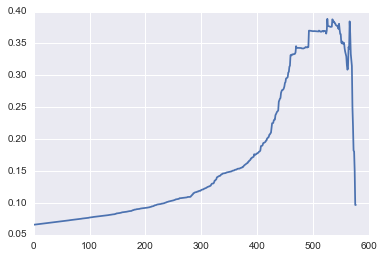

In [19]:
# plot score against clustering step
F1 = [trueScore(x,(y_D+np.eye(t0.shape[0]))) for x in T]
n_t = np.array(range(len(F1)))
plt.plot(n_t,np.array(F1))

In [20]:
n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
n_cluster

51

In [36]:
#precision = [trueScore(x,(y_D+np.eye(t0.shape[0])),'precision') for x in T]
#n_t = np.array(range(len(precision)))
#plt.plot(n_t,np.array(precision))
#recall = [trueScore(x,(y_D+np.eye(t0.shape[0])),'recall') for x in T]
#n_t = np.array(range(len(recall)))
#plt.plot(n_t,np.array(recall))

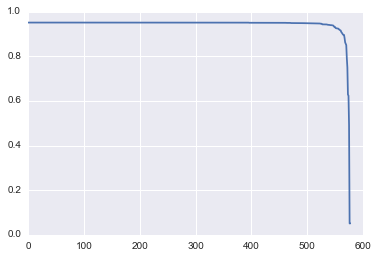

In [21]:
acc = [trueScore(x,(y_D+np.eye(t0.shape[0])),'accuracy') for x in T]
n_t = np.array(range(len(acc)))
plt.plot(n_t,np.array(acc))

In [22]:
acc[n_cluster]

0.95085739001408709

# Test error

## Read Data

## Data set 3 n_author = 61

In [58]:
# read data
n_author = 61
i = 3
fpath = '../data/feature'+str(i)+'.csv'
test_df = pd.DataFrame.from_csv(fpath)
n = int(np.sqrt(test_df.shape[0]))
test_X = test_df.ix[:,['coauthor','journal','tfidf_sml','edit_dist','edit_dist_sml','bigram','trigram']].values
test_y = test_df['is_same'].values
test_y_D = test_y.reshape((n,n))
test_y_D = np.triu(test_y_D, k=1)
test_t0 = np.array([i for i in range(n)])
test_w0 = np.copy(w)
test_M0 = test_X.dot(test_w0).reshape((n,n))
test_M0 = np.triu(test_M0, k=1)
T = predTree(test_t0,test_X,w,test_t0.shape[0])

In [59]:
# plot score against clustering step
F1 = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0]))) for x in T]
acc = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0])),'accuracy') for x in T]

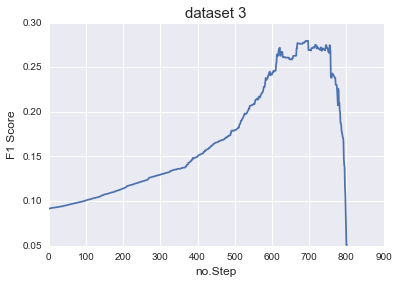

In [60]:
n_t = np.array(range(len(F1)))
plt.ylabel('F1 Score',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(F1))
save_path = '../figs/alg5_F1_'+str(i)+'.png'
plt.savefig(save_path)

In [61]:
n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
print('predicted distinct author number is: ',n_cluster)
print('F1 score at predicted author number is: ',round(F1[n-n_cluster],3))
print('F1 score at true author number is: ',round(F1[n-n_author],3))

predicted distinct author number is:  107
F1 score at predicted author number is:  0.28
F1 score at true author number is:  0.27


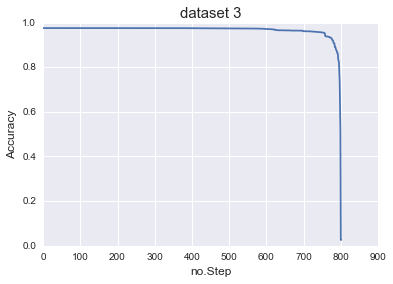

In [62]:
n_t = np.array(range(len(acc)))
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(acc))
save_path = '../figs/alg5_acc_'+str(i)+'.png'
plt.savefig(save_path)

In [63]:
#n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
#print('predicted distinct author number is: ',n_cluster)
print('accuracy at predicted author number is: ',round(acc[n-n_cluster],3))
print('accuracy at true author number is: ',round(acc[n-n_author],3))

accuracy at predicted author number is:  0.964
accuracy at true author number is:  0.957


## Data set 5 n_author = 100

In [23]:
# read data
n_author = 100
i = 5
fpath = '../data/feature'+str(i)+'.csv'
test_df = pd.DataFrame.from_csv(fpath)
n = int(np.sqrt(test_df.shape[0]))
test_X = test_df.ix[:,['coauthor','journal','tfidf_sml','edit_dist','edit_dist_sml','bigram','trigram']].values
test_y = test_df['is_same'].values
test_y_D = test_y.reshape((n,n))
test_y_D = np.triu(test_y_D, k=1)
test_t0 = np.array([i for i in range(n)])
test_w0 = np.copy(w)
test_M0 = test_X.dot(test_w0).reshape((n,n))
test_M0 = np.triu(test_M0, k=1)
T = predTree(test_t0,test_X,w,test_t0.shape[0])

In [ ]:
# plot score against clustering step
F1 = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0]))) for x in T]
acc = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0])),'accuracy') for x in T]

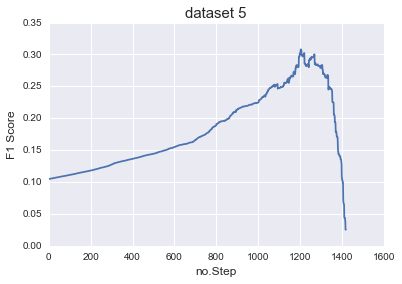

In [46]:
n_t = np.array(range(len(F1)))
plt.ylabel('F1 Score',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(F1))
save_path = '../figs/alg5_F1_'+str(i)+'.png'
plt.savefig(save_path)

In [56]:
n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
print('predicted distinct author number is: ',n_cluster)
print('F1 score at predicted author number is: ',round(F1[n-n_cluster],3))
print('F1 score at true author number is: ',round(F1[n-n_author],3))

predicted distinct author number is:  215
F1 score at predicted author number is:  0.308
F1 score at true author number is:  0.268


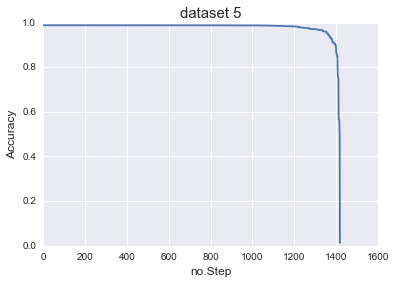

In [45]:
n_t = np.array(range(len(acc)))
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(acc))
save_path = '../figs/alg5_acc_'+str(i)+'.png'
plt.savefig(save_path)

In [57]:
#n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
#print('predicted distinct author number is: ',n_cluster)
print('accuracy at predicted author number is: ',round(acc[n-n_cluster],3))
print('accuracy at true author number is: ',round(acc[n-n_author],3))

accuracy at predicted author number is:  0.983
accuracy at true author number is:  0.967


## Data set 8 n_author = 30

In [64]:
# read data
n_author = 30
i = 8
fpath = '../data/feature'+str(i)+'.csv'
test_df = pd.DataFrame.from_csv(fpath)
n = int(np.sqrt(test_df.shape[0]))
test_X = test_df.ix[:,['coauthor','journal','tfidf_sml','edit_dist','edit_dist_sml','bigram','trigram']].values
test_y = test_df['is_same'].values
test_y_D = test_y.reshape((n,n))
test_y_D = np.triu(test_y_D, k=1)
test_t0 = np.array([i for i in range(n)])
test_w0 = np.copy(w)
test_M0 = test_X.dot(test_w0).reshape((n,n))
test_M0 = np.triu(test_M0, k=1)
T = predTree(test_t0,test_X,w,test_t0.shape[0])

In [65]:
# plot score against clustering step
F1 = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0]))) for x in T]
acc = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0])),'accuracy') for x in T]

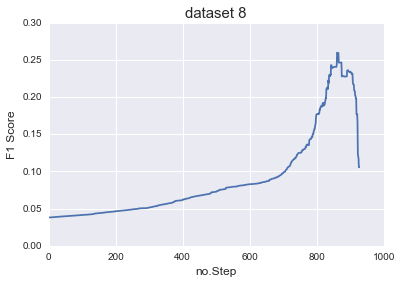

In [66]:
n_t = np.array(range(len(F1)))
plt.ylabel('F1 Score',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(F1))
save_path = '../figs/alg5_F1_'+str(i)+'.png'
plt.savefig(save_path)

In [67]:
n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
print('predicted distinct author number is: ',n_cluster)
print('F1 score at predicted author number is: ',round(F1[n-n_cluster],3))
print('F1 score at true author number is: ',round(F1[n-n_author],3))

predicted distinct author number is:  66
F1 score at predicted author number is:  0.26
F1 score at true author number is:  0.234


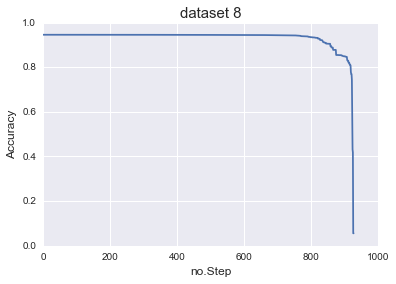

In [68]:
n_t = np.array(range(len(acc)))
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(acc))
save_path = '../figs/alg5_acc_'+str(i)+'.png'
plt.savefig(save_path)

In [69]:
#n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
#print('predicted distinct author number is: ',n_cluster)
print('accuracy at predicted author number is: ',round(acc[n-n_cluster],3))
print('accuracy at true author number is: ',round(acc[n-n_author],3))

accuracy at predicted author number is:  0.888
accuracy at true author number is:  0.849


## Data set 13 n_author = 86

In [71]:
# read data
n_author = 86
i = 13
fpath = '../data/feature'+str(i)+'.csv'
test_df = pd.DataFrame.from_csv(fpath)
n = int(np.sqrt(test_df.shape[0]))
test_X = test_df.ix[:,['coauthor','journal','tfidf_sml','edit_dist','edit_dist_sml','bigram','trigram']].values
test_y = test_df['is_same'].values
test_y_D = test_y.reshape((n,n))
test_y_D = np.triu(test_y_D, k=1)
test_t0 = np.array([i for i in range(n)])
test_w0 = np.copy(w)
test_M0 = test_X.dot(test_w0).reshape((n,n))
test_M0 = np.triu(test_M0, k=1)
T = predTree(test_t0,test_X,w,test_t0.shape[0])

In [75]:
# plot score against clustering step
F1 = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0]))) for x in T]
acc = [trueScore(x,(test_y_D+np.eye(test_t0.shape[0])),'accuracy') for x in T]

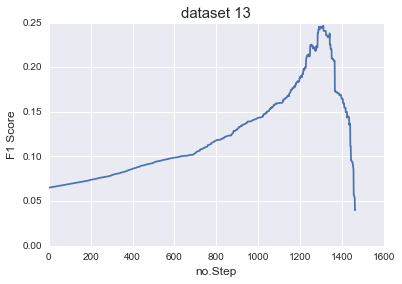

In [73]:
n_t = np.array(range(len(F1)))
plt.ylabel('F1 Score',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(F1))
save_path = '../figs/alg5_F1_'+str(i)+'.png'
plt.savefig(save_path)

In [74]:
n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
print('predicted distinct author number is: ',n_cluster)
print('F1 score at predicted author number is: ',round(F1[n-n_cluster],3))
print('F1 score at true author number is: ',round(F1[n-n_author],3))

predicted distinct author number is:  152
F1 score at predicted author number is:  0.247
F1 score at true author number is:  0.172


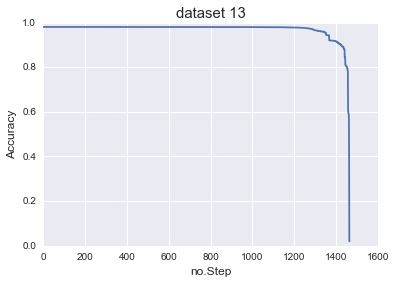

In [76]:
n_t = np.array(range(len(acc)))
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('no.Step',fontsize=12)
title = 'dataset '+str(i)
plt.title(title,fontsize=15)
plt.plot(n_t,np.array(acc))
save_path = '../figs/alg5_acc_'+str(i)+'.png'
plt.savefig(save_path)

In [77]:
#n_cluster = np.unique(T[F1.index(max(F1))]).shape[0]
#print('predicted distinct author number is: ',n_cluster)
print('accuracy at predicted author number is: ',round(acc[n-n_cluster],3))
print('accuracy at true author number is: ',round(acc[n-n_author],3))

accuracy at predicted author number is:  0.964
accuracy at true author number is:  0.919
